## This algorithm treats the image just like a topographical map where the brightness of each point representing its height and finds the lines that run along the top of ridges.
### Any grayscale image can be treated as a topographic surface where high intensity denotes peaks and hills and low density denotes valleys.
# This algorithm is especially useful for segmenting images into background and foreground in situtaions that are difficult for other algorithms.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def display(img, cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

In [4]:
sep_coins = cv2.imread('../Computer-Vision-with-Python/DATA/pennies.jpg')

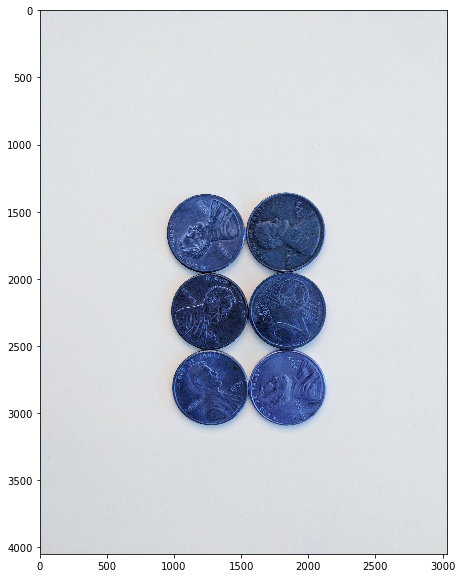

In [5]:
display(sep_coins)

#### Approaching with conventional method

In [6]:
# We will use median blur on this image because we don't really need the contents of the image, just the shape
sep_blur = cv2.medianBlur(sep_coins, 25)

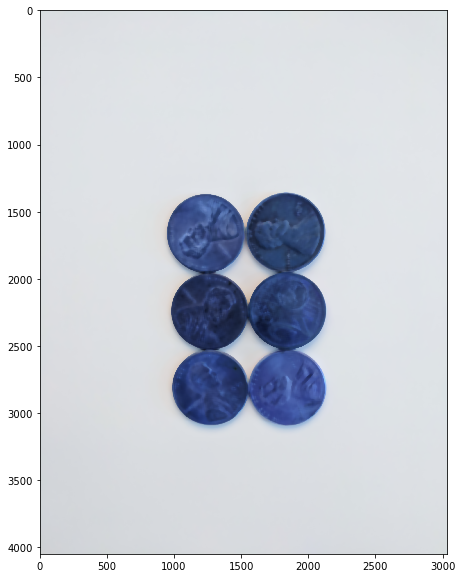

In [7]:
display(sep_blur)

In [8]:
gray_sep = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)

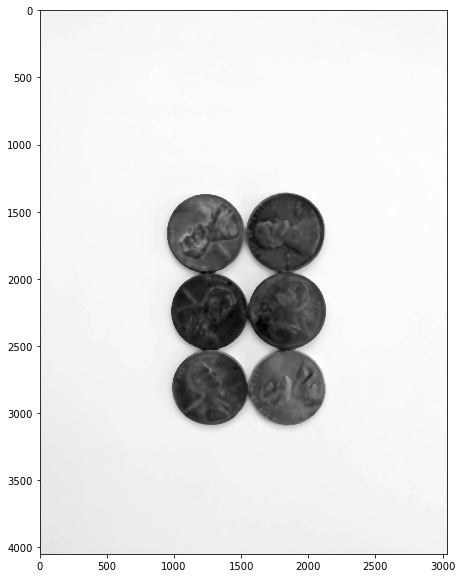

In [9]:
display(gray_sep)

In [10]:
ret, ret_sep = cv2.threshold(gray_sep, 160,255, cv2.THRESH_BINARY_INV)

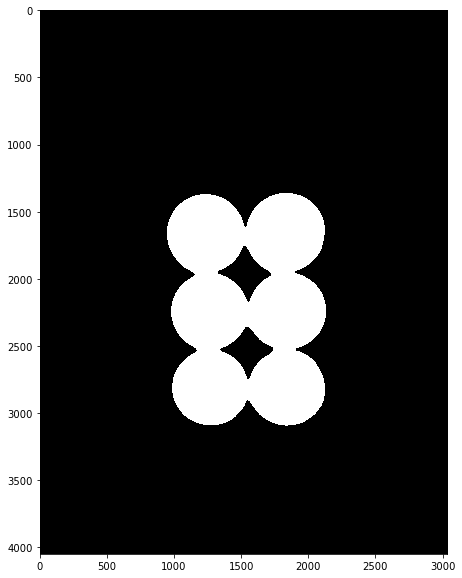

In [11]:
display(ret_sep)

In [12]:
image,contours, hierarchy = cv2.findContours(ret_sep.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )

In [13]:
for i in range(len(contours)):
    if hierarchy [0][i][3] == -1:
        cv2.drawContours(sep_coins, contours,i,(255,0,0), 10)

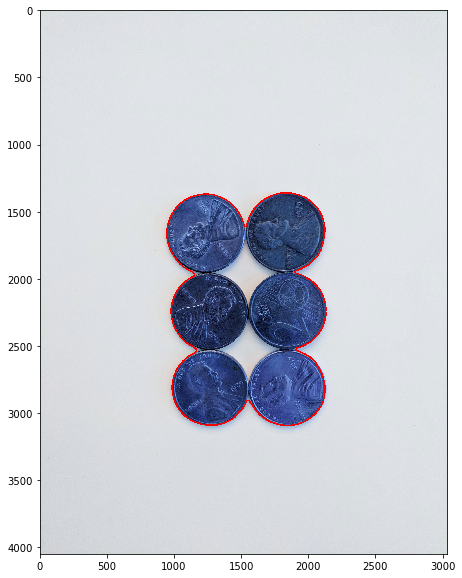

In [14]:
display(sep_coins)

#### Approaching with Watershed Algorithm for image segmentation

In [15]:
img = cv2.imread('../Computer-Vision-with-Python/DATA/pennies.jpg')

In [16]:
img = cv2.medianBlur(img, 35)

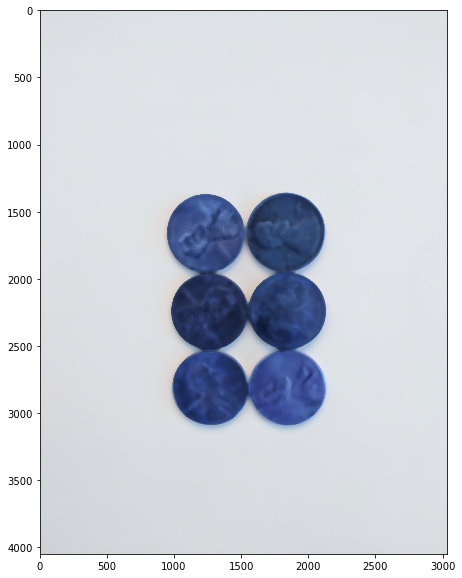

In [17]:
display(img)

In [18]:
gray_blur = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [19]:
ret, threshold =cv2.threshold(gray_blur, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

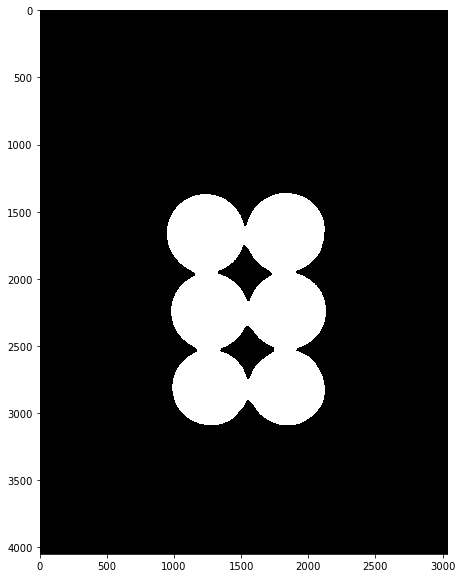

In [20]:
display(threshold)

In [21]:
# NOISE REMOVAL IS VERY COMMON IN IMAGE PROCESSING
kernel = np.ones((3,3), dtype= np.uint8)

In [22]:
kernel

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

In [23]:
opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations = 2 )

In [24]:
# DISTANCE TRANSFORM
dist_trans = cv2.distanceTransform(opening, cv2.DIST_L2,5)

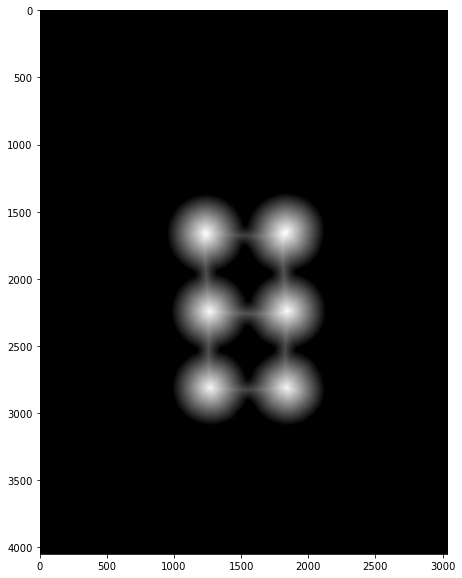

In [25]:
display(dist_trans)

In [26]:
ret, sure_fg = cv2.threshold(dist_trans, 0.7*dist_trans.max(), 255,0)

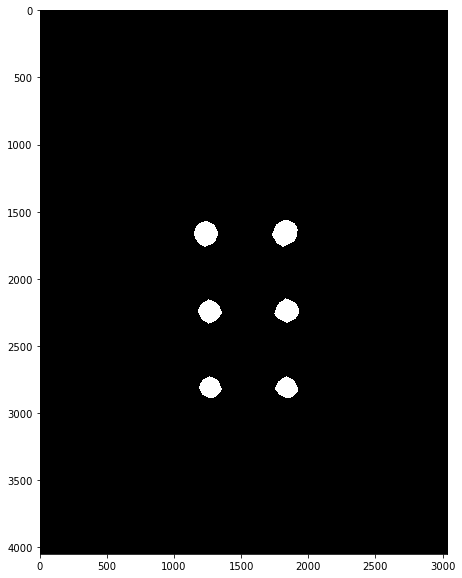

In [27]:
display(sure_fg)

In [28]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)

In [29]:
sure_fg = np.uint8(sure_fg)

In [30]:
unknown = cv2.subtract(sure_bg, sure_fg)

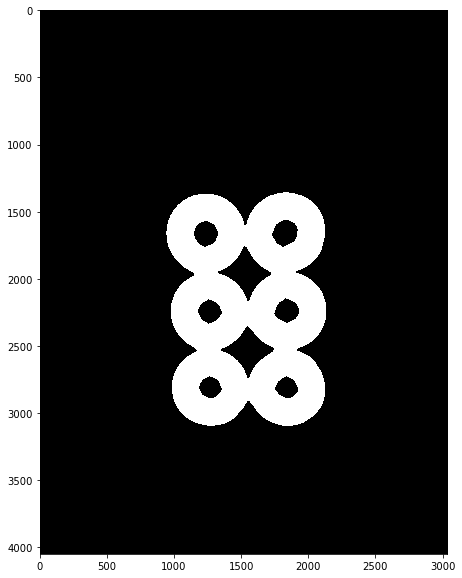

In [31]:
display(unknown)

In [32]:
ret,markers = cv2.connectedComponents(sure_fg)

In [33]:
markers = markers + 1

In [34]:
markers[unknown==255] = 0

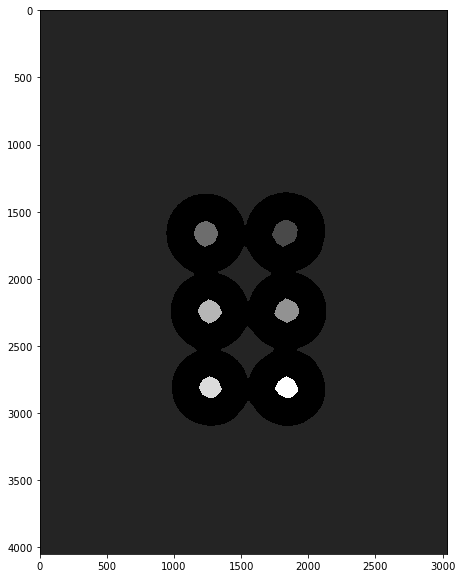

In [35]:
display(markers)

In [36]:
markers = cv2.watershed(img,markers)

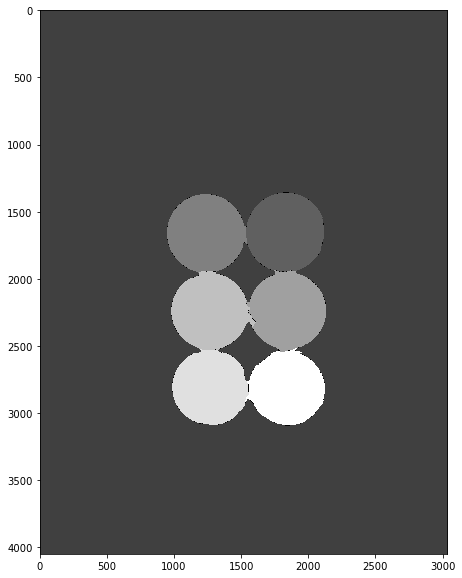

In [37]:
display(markers)

In [38]:
image,contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )

In [39]:
for i in range(len(contours)):
    if hierarchy [0][i][3] == -1:
        cv2.drawContours(sep_coins, contours,i,(255,0,0), 10)

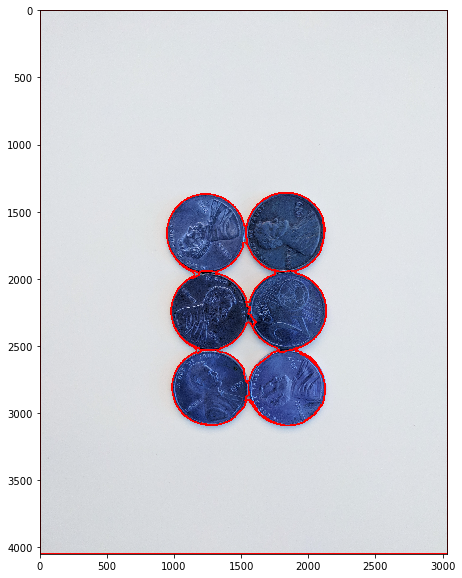

In [40]:
display(sep_coins)

# Custom seeds with watershed algorithm

In [41]:
road = cv2.imread('../Computer-Vision-with-Python/DATA/road_image.jpg')

In [42]:
road_copy = road.copy()

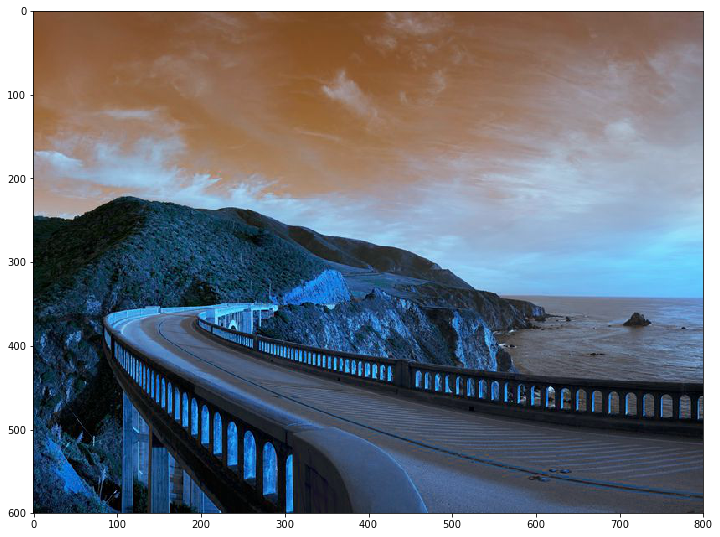

In [43]:
display(road_copy)

In [44]:
road.shape

(600, 800, 3)

In [45]:
marker_img = np.zeros(road.shape[:2], dtype=np.int32)

In [46]:
seg = np.zeros(road.shape, dtype = np.uint8)

In [47]:
marker_img.shape

(600, 800)

In [48]:
seg.shape

(600, 800, 3)

In [49]:
from matplotlib import cm

In [50]:
cm.tab10(0)[:3]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [51]:
def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3])*255)

In [52]:
colors = []
for i in range(10):
    colors.append(create_rgb(i))

In [53]:
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [54]:
### GLOBAL VARIABLES 
current_marker = 1
#COLOR CHOICE
n_markers = 10
# Marks updated by watershed
marks_updated = False

In [55]:
### CALLBACK FUNCTION

def mouse_callback(event,x,y,flags,param):
    global marks_updated
    
    if event == cv2.EVENT_LBUTTONDOWN:
        #MARKERS PASSED TO WATERSHED
        cv2.circle(marker_img, (x,y),10,(current_marker), -1)
        
        # USER SEES ON ROAD IMAGE
        cv2.circle(road_copy, (x,y), 10, colors[current_marker],-1)
        
        marks_updated = True

In [56]:
#WHILE TRUE
cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image', mouse_callback)


while True:
    cv2.imshow('Watershed segments', seg)
    cv2.imshow('Road Iamge', road_copy)
    
    
    # CLOSE ALL WINDOWS
    k = cv2.waitKey(1)
    
    if k ==27:
        break
        
    # CLEAR ALL THE COLORS
    elif k ==ord('c'):
        road_copy = road.copy()
        marker_img = np.zeros(road.shape[:2], dtype=np.int32)
        seg = np.zeros(road.shape, dtype = np.uint8)
    
    
    #UPDATE COLOR CHOICE
    
    elif k > 0 and chr(k).isdigit():
        current_marker = int(chr(k))
        
    # UPDATE THE MARKERS
    
    if marks_updated:
        marker_image_copy = marker_img.copy()
        cv2.watershed(road,marker_image_copy)
        seg = np.zeros(road.shape, dtype=np.uint8)
        
        for color_ind in range(n_markers):
            # COLORING SEGMENTS
            seg[marker_image_copy == color_ind()]  = colors[color_ind]
        
    
        
cv2.destroyAllWindows()

TypeError: 'int' object is not callable